# Convolutional Neural Networks

## Part 1: Scanning MLPs and Position Invariance

### 1.1 The Problem: Why Standard MLPs Fail at Position Invariance

Pattern classification tasks often require detecting whether a specific pattern exists anywhere in an input signal, regardless of its location. Consider the following problems:

- Does the word "welcome" occur anywhere in this audio signal?
- Is there a flower anywhere in this image?

In such problems:

| Criterion | Importance |
|-----------|------------|
| Location of pattern | Does not matter |
| Presence of pattern | Matters |

**The Standard MLP Formulation:**

A standard Multi-Layer Perceptron treats the entire input as a flat vector and computes:

$$\mathbf{y} = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$$

**Limitations of Standard MLPs:**

1. Moving a pattern by one position produces a completely different input vector
2. The MLP has no built-in notion of shift invariance
3. Each weight $w_{ij}$ is tied to a specific input position

---

### 1.2 The Solution: Scanning

**Key Insight:** An MLP can be made position-invariant by scanning the input instead of consuming it all at once.

**The Scanning Procedure:**

| Step | Operation | Description |
|:----:|-----------|-------------|
| 1 | Choose window size | 1D: $K$ time steps; 2D: $K \times K$ pixels |
| 2 | Extract local patch | At position $t$, take subset: $\mathbf{x}_{t:t+K-1}$ |
| 3 | Apply same MLP | Use identical weights $\mathbf{W}$ and biases $\mathbf{b}$ |
| 4 | Slide and repeat | Move window by stride $s$; produces one output per location |
| 5 | Aggregate outputs | Apply max, softmax, or perceptron for final decision |

---

### 1.3 Weight Matrix Structure: Regular vs Scanning MLP

**Regular MLP:**
- Every neuron connects to all inputs
- Weight matrix is dense
- Every weight is unique

**Scanning MLP:**
- Each neuron connects to only a subset of inputs
- Same subset pattern is repeated across positions
- Same weights are reused (weight tying)

**Resulting Structure:**
- Sparse weight matrix
- Block-structured connectivity
- Identical blocks at each position
- Shared parameters across all positions

**Important:** This entire structure is equivalent to one giant MLP with weight tying.

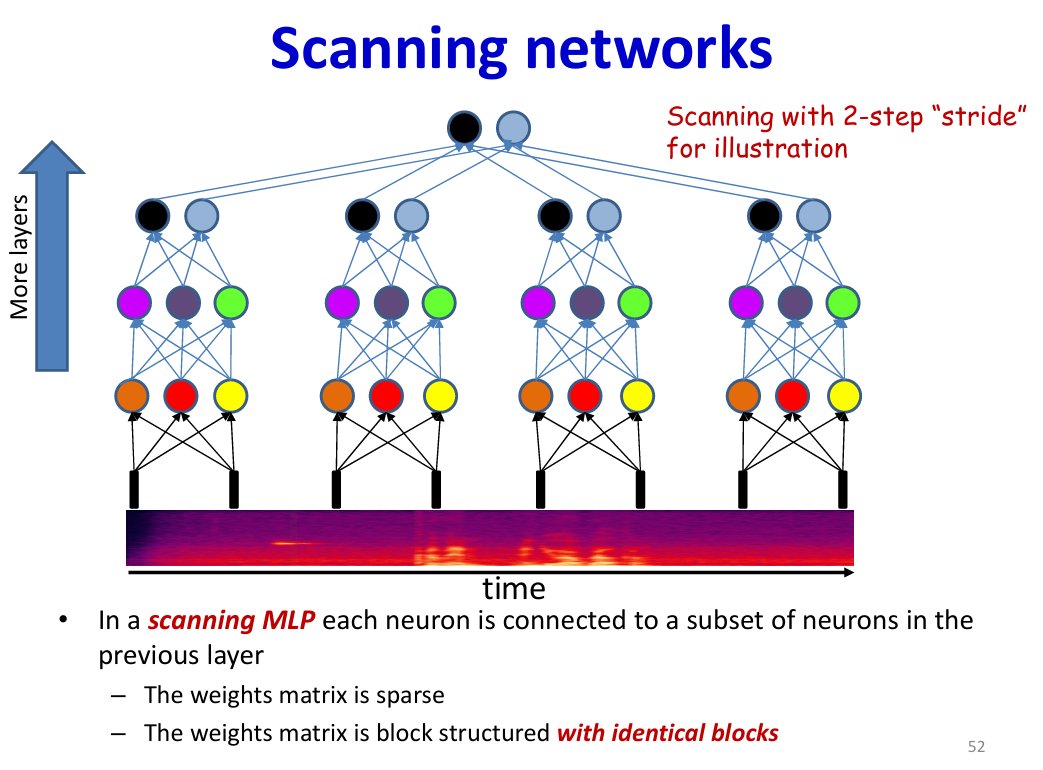

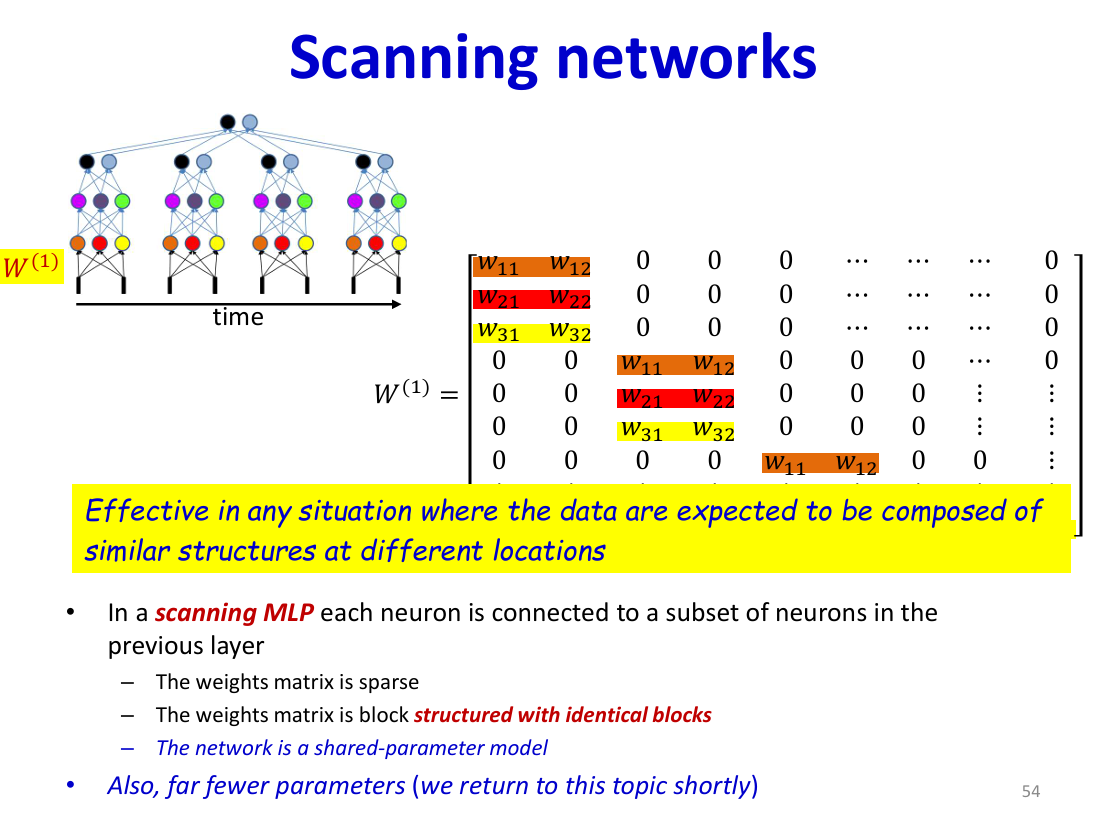

---

### 1.4 Shared Parameter Model

The scanning MLP is a shared-parameter model. When a weight $w_{11}$ changes in one location, it must change everywhere that weight is used.

**Training with Shared Parameters:**

During backpropagation, gradients from all locations are summed:

$$\frac{\partial \mathcal{L}}{\partial w_s} = \sum_{t=1}^{T-K+1} \frac{\partial \mathcal{L}}{\partial w_s^{(t)}}$$

where $w_s$ is the shared parameter. This summation is what enforces shift invariance.

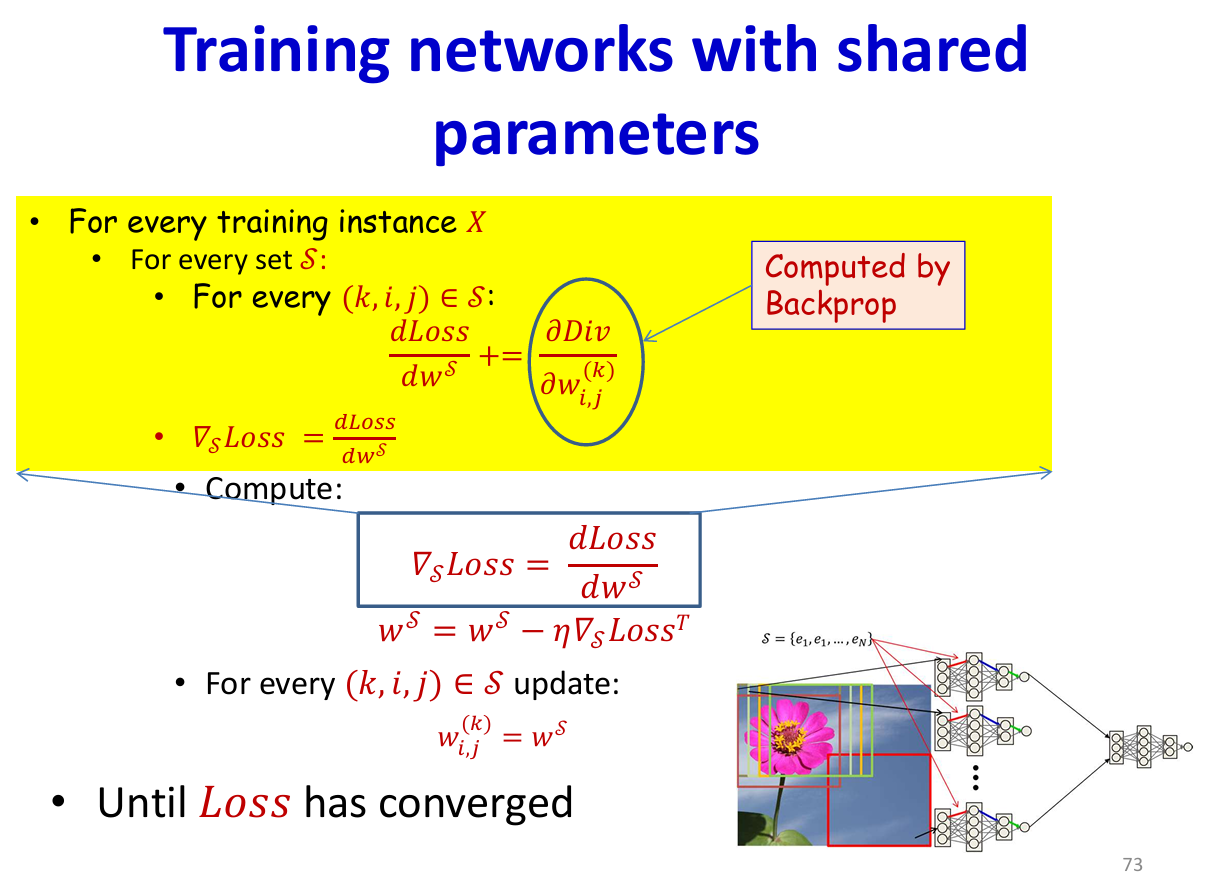

---

### 1.5 Stride

**Definition:** Stride ($s$) is the distance the scanning window moves between consecutive evaluations.

**Output Size Formula:**

$$\text{Output size} = \left\lfloor \frac{T - K}{s} \right\rfloor + 1$$

| Stride Value | Characteristics |
|--------------|-----------------|
| $s = 1$ | Maximum overlap, finest resolution |
| $s = K$ | No overlap, fastest computation |

## Part 2: Scanning MLP Algorithm (1D)

This algorithm scans an input by sliding a window, applies the same MLP at each position using shared weights, computes activations layer-by-layer locally, and aggregates all location-wise outputs into a single decision.

### 2.1 Algorithm Pseudocode

```
for l = 1:L                         // iterate over layers
    for t = 1:T-K+1                 // scan over time/position
        for j = 1:D_l               // neurons in layer l

            if (l == 1)             // first layer operates on input
                y(0,:,t) = x(:, t:t+K-1)
            end

            z(l,j,t) = b(l,j)       // initialize with bias

            for i = 1:D_{l-1}       // sum over previous layer neurons
                z(l,j,t) += w(l,i,j) * y(l-1,i,t)
            end

            y(l,j,t) = activation(z(l,j,t))
        end
    end
end

Y = softmax(y(L,:,1) .. y(L,:,T-K+1))   // aggregate all positions
```

---

### 2.2 Mathematical Formulation

**Forward Pass at Position $t$:**

**Input Layer (Layer 0):**

$$\mathbf{y}^{(0)}_t = \mathbf{x}_{t:t+K-1}$$

**Hidden Layers ($l = 1, \ldots, L$):**

Pre-activation:
$$z^{(l)}_{j,t} = b^{(l)}_j + \sum_{i=1}^{D_{l-1}} w^{(l)}_{i,j} \cdot y^{(l-1)}_{i,t}$$

Activation:
$$y^{(l)}_{j,t} = \sigma\left(z^{(l)}_{j,t}\right)$$

**Final Aggregation:**

$$\mathbf{Y} = \text{softmax}\left(\mathbf{y}^{(L)}_{:,1}, \mathbf{y}^{(L)}_{:,2}, \ldots, \mathbf{y}^{(L)}_{:,T-K+1}\right)$$

---

### 2.3 Symbol Reference

| Symbol | Description |
|--------|-------------|
| $\mathbf{x}$ | Input signal (e.g., spectrogram or time series) |
| $K$ | Window (patch) width |
| $T$ | Total input length |
| $l$ | Layer index |
| $j$ | Neuron index in current layer |
| $i$ | Neuron index in previous layer |
| $D_l$ | Number of neurons in layer $l$ |
| $y^{(l)}_{j,t}$ | Output of neuron $j$ in layer $l$ at position $t$ |
| $z^{(l)}_{j,t}$ | Pre-activation (weighted sum plus bias) |
| $w^{(l)}_{i,j}$ | Weight from neuron $i$ (layer $l-1$) to neuron $j$ (layer $l$) |
| $b^{(l)}_j$ | Bias of neuron $j$ in layer $l$ |

---

### 2.4 Output Dimensions

For input length $T$ and kernel size $K$ with stride $s=1$:

$$\text{Number of output positions} = T - K + 1$$

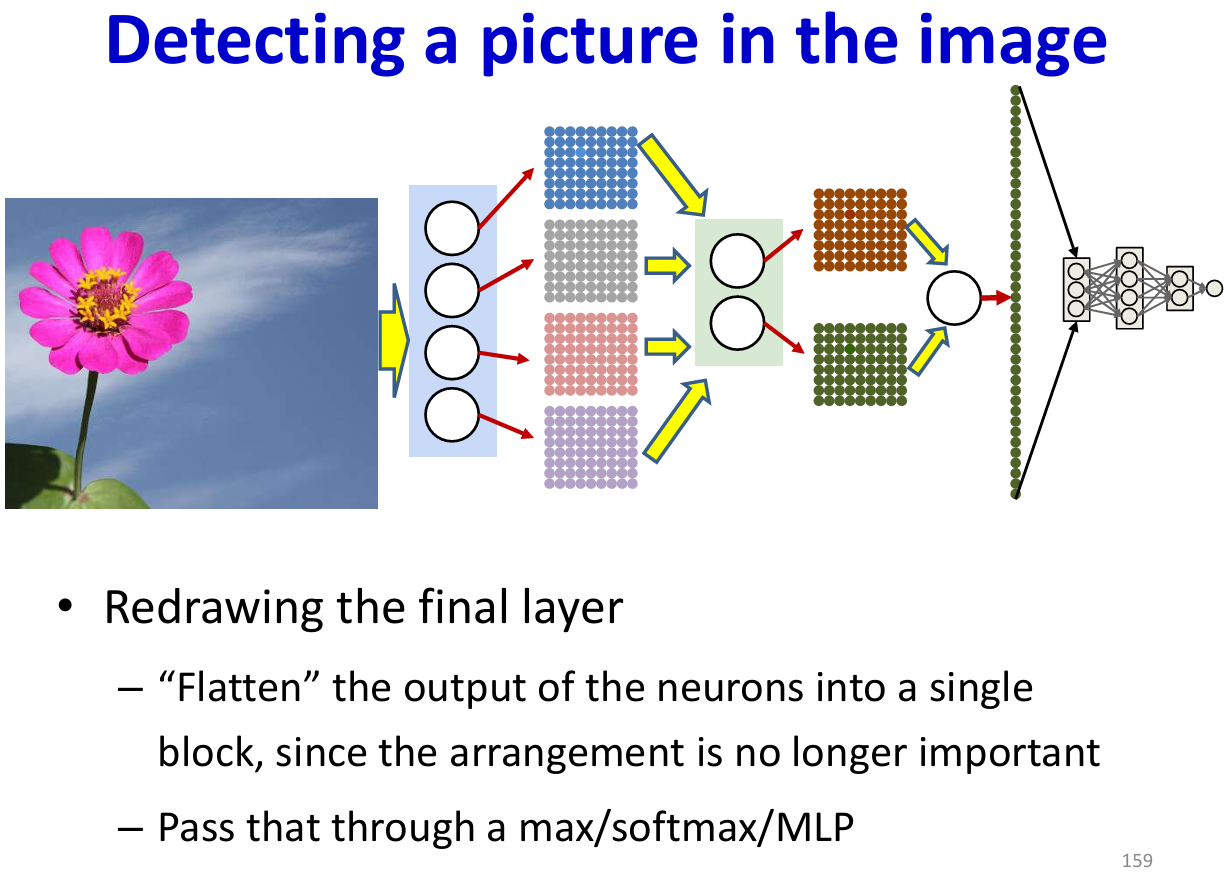

## Part 3: Convolutional Neural Network (CNN) Algorithm

A CNN extends the scanning MLP to 2D spatial data (images), scanning with kernels over both width and height dimensions.

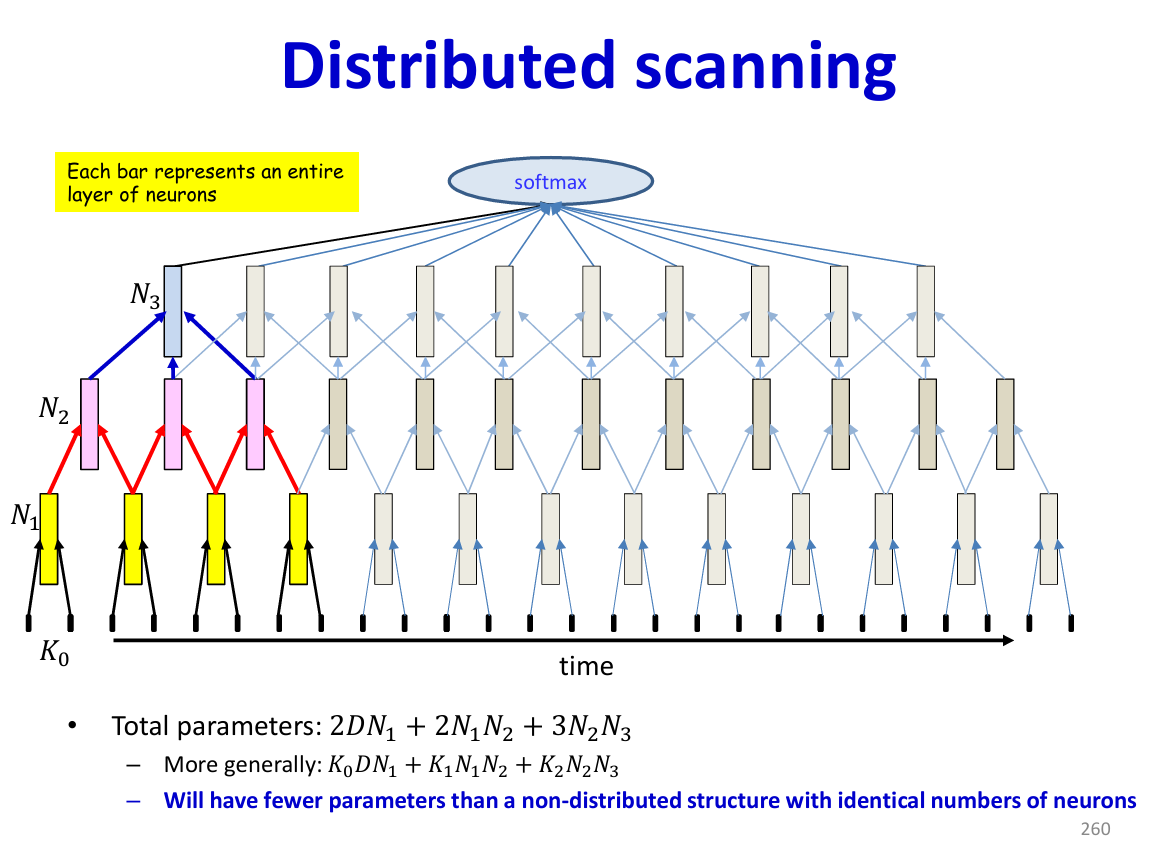

---

### 3.1 Algorithm Pseudocode

```
Y(0,:,:,:) = Image                              // Initialize with input image

for l = 1:L                                     // iterate over layers
    for x = 1:W_{l-1} - K_l + 1                 // scan over width
        for y = 1:H_{l-1} - K_l + 1             // scan over height
            for j = 1:D_l                       // output filters in layer l

                z(l,j,x,y) = 0                  // initialize accumulator

                for i = 1:D_{l-1}               // input channels
                    for x' = 1:K_l              // kernel width
                        for y' = 1:K_l          // kernel height
                            z(l,j,x,y) += w(l,i,j,x',y') * Y(l-1,i,x+x'-1,y+y'-1)
                        end
                    end
                end

                Y(l,j,x,y) = activation(z(l,j,x,y))
            end
        end
    end
end

Y = softmax( Y(L,:,1,1) .. Y(L,:,W-K+1,H-K+1) )  // aggregate all spatial positions
```

---

### 3.2 Mathematical Formulation

**Convolution Operation:**

For each layer $l$, output channel $j$, and spatial position $(x, y)$:

$$z^{(l)}_{j,x,y} = b^{(l)}_j + \sum_{i=1}^{D_{l-1}} \sum_{x'=1}^{K_l} \sum_{y'=1}^{K_l} w^{(l)}_{i,j,x',y'} \cdot Y^{(l-1)}_{i, x+x'-1, y+y'-1}$$

$$Y^{(l)}_{j,x,y} = \sigma\left(z^{(l)}_{j,x,y}\right)$$

**Compact Notation (Convolution Operator):**

$$\mathbf{Y}^{(l)}_j = \sigma\left( \sum_{i=1}^{D_{l-1}} \mathbf{W}^{(l)}_{i,j} * \mathbf{Y}^{(l-1)}_i + b^{(l)}_j \right)$$

where $*$ denotes the 2D convolution operation.

---

### 3.3 Symbol Reference

| Symbol | Description |
|--------|-------------|
| $\text{Image}$ | Input image (2D signal with channels) |
| $Y^{(l)}_{i,x,y}$ | Output of channel $i$ in layer $l$ at spatial location $(x,y)$ |
| $l$ | Layer index |
| $j$ | Output filter (channel) index |
| $i$ | Input channel index |
| $D_l$ | Number of filters (output channels) in layer $l$ |
| $K_l$ | Kernel (filter) size at layer $l$ |
| $W_l, H_l$ | Width and height of feature maps at layer $l$ |
| $w^{(l)}_{i,j,x',y'}$ | Weight connecting input channel $i$ to output channel $j$ at kernel offset $(x', y')$ |
| $b^{(l)}_j$ | Bias for filter $j$ in layer $l$ |

---

### 3.4 Output Feature Map Dimensions

For input size $W \times H$, kernel size $K$, padding $P$, and stride $S$:

$$W_{\text{out}} = \left\lfloor \frac{W - K + 2P}{S} \right\rfloor + 1$$

$$H_{\text{out}} = \left\lfloor \frac{H - K + 2P}{S} \right\rfloor + 1$$

---

### 3.5 Key Insight

A CNN is a scanning MLP whose scanning operation has been algebraically reorganized into convolution for efficiency and structure.

| Scanning MLP | CNN |
|--------------|-----|
| Explicit loop over positions | Convolution operator |
| Same weights at each position | Shared filter weights |
| Sequential computation | Parallelizable matrix operations |

Both architectures achieve shift invariance through weight sharing across spatial locations.

## Part 4: Summary -- From MLP to CNN

### 4.1 The Progression

| Architecture | Description |
|--------------|-------------|
| Standard MLP | Dense connections, no spatial awareness, position-dependent |
| Scanning MLP | Shared weights, slides over input, achieves shift invariance |
| CNN | Scanning MLP reorganized as convolution, efficient 2D extension |

---

### 4.2 Key Equations

**Standard MLP Layer:**

$$\mathbf{y} = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$$

**Scanning MLP (1D):**

$$y^{(l)}_{j,t} = \sigma\left(b^{(l)}_j + \sum_{i} w^{(l)}_{i,j} \cdot y^{(l-1)}_{i,t}\right)$$

**CNN Convolution (2D):**

$$Y^{(l)}_{j,x,y} = \sigma\left(b^{(l)}_j + \sum_{i} \sum_{x'} \sum_{y'} w^{(l)}_{i,j,x',y'} \cdot Y^{(l-1)}_{i,x+x'-1,y+y'-1}\right)$$

---

### 4.3 Why Shift Invariance Matters

$$\text{If } f(\mathbf{x}) = \text{"pattern detected"} \implies f(\text{shift}(\mathbf{x})) = \text{"pattern detected"}$$

This property is achieved through:

1. **Weight sharing:** The same weights $\mathbf{W}$ are applied at every position
2. **Local receptive fields:** Each neuron observes only a local patch of the input
3. **Aggregation:** Max pooling or softmax over all positions

## Part 5: Historical Background and General CNN Architecture

### 5.1 The Neocognitron

One of the earliest architectures resembling modern CNNs was developed by Kunihiko Fukushima in 1980, called the Neocognitron.

| Layer Type | Function |
|------------|----------|
| S-plane (Simple cells) | Extracts simple, local features |
| C-plane (Complex cells) | Pools features for position tolerance |

The alternating S-C structure inspired modern CNN architectures with their convolution-pooling patterns.

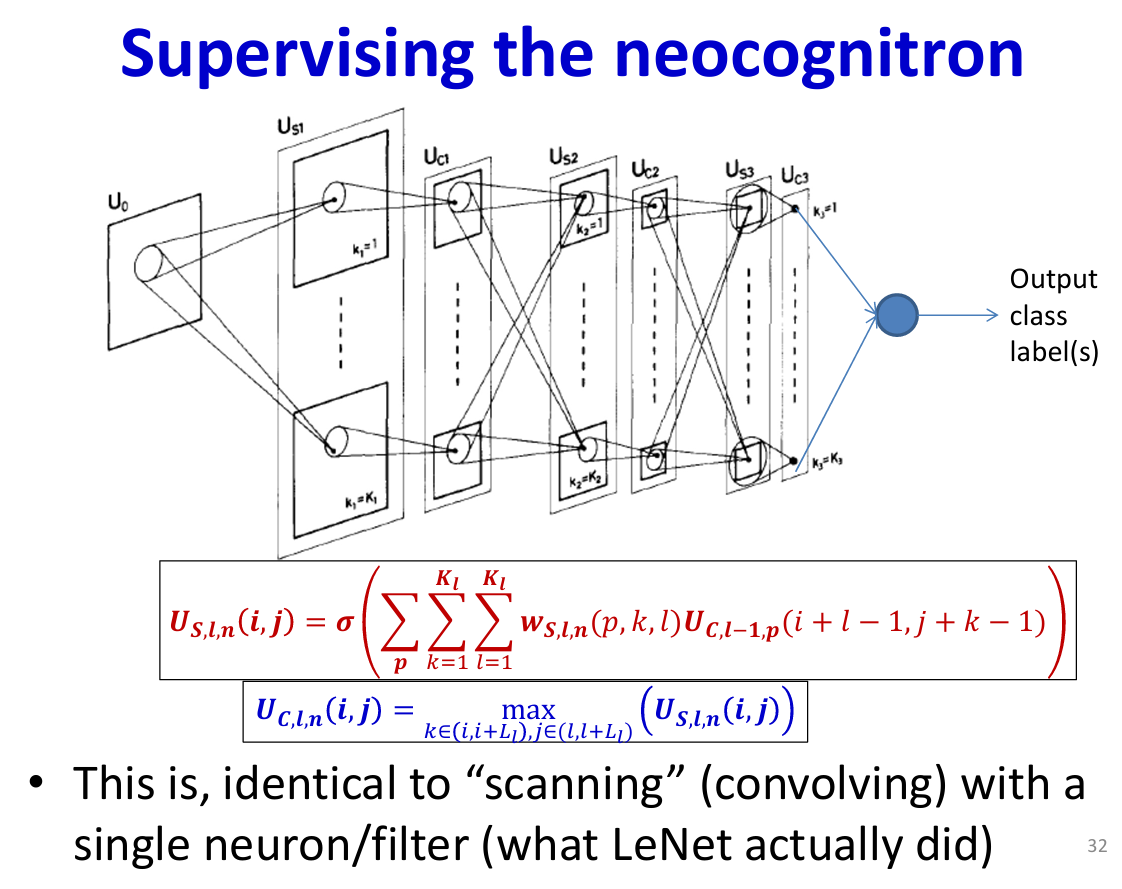

---

### 5.2 General CNN Architecture

A Convolutional Neural Network is a hierarchical pattern-processing system composed of three major blocks:

| Block | Name | Components | Learnable |
|:-----:|------|------------|:---------:|
| A | Feature Extraction | Convolutional layers, Pointwise activations | Yes |
| B | Robustness and Compression | Pooling layers, Downsampling (stride) | No |
| C | Decision Making | Multi-Layer Perceptron, Softmax | Yes |

**Key Design Principle:**

$$\text{Early layers} \rightarrow \text{local, simple patterns} \rightarrow \text{Deeper layers} \rightarrow \text{abstract patterns} \rightarrow \text{Final layers} \rightarrow \text{global reasoning}$$

---

### 5.3 Convolutional Layer

A convolutional layer comprises a series of maps (corresponding to S-planes in the Neocognitron), variously called feature maps or activation maps.

Each activation map has two components:

1. An affine map, obtained by convolution over maps in the previous layer
2. An activation function that operates pointwise on the output of the convolution

**Components of a Convolutional Layer:**

| Component | Description |
|-----------|-------------|
| Input maps | Feature maps from previous layer (or input image) |
| Filters (kernels) | Learnable weight tensors |
| Affine map | Pre-activation output: $\mathbf{Z} = \mathbf{W} * \mathbf{Y} + \mathbf{b}$ |
| Activation function | Pointwise nonlinearity: $\sigma(\cdot)$ |
| Output activation maps | Final feature maps: $\mathbf{Y}^{(l)} = \sigma(\mathbf{Z}^{(l)})$ |

**Note:** Each output map corresponds to exactly one filter.

---

### 5.4 The Convolution Operation

The convolution operation slides a filter over the input and computes weighted sums:

$$Z_{j}(x,y) = b_j + \sum_{p=1}^{D_{l-1}} \sum_{k=0}^{K-1} \sum_{m=0}^{K-1} W_{p,j}(k,m) \cdot Y_p(x+k, y+m)$$

where:
- $Z_j(x,y)$ is the pre-activation at position $(x,y)$ for filter $j$
- $W_{p,j}(k,m)$ is the filter weight at offset $(k,m)$ connecting input channel $p$ to output channel $j$
- $Y_p$ is input feature map $p$
- $b_j$ is the bias for filter $j$

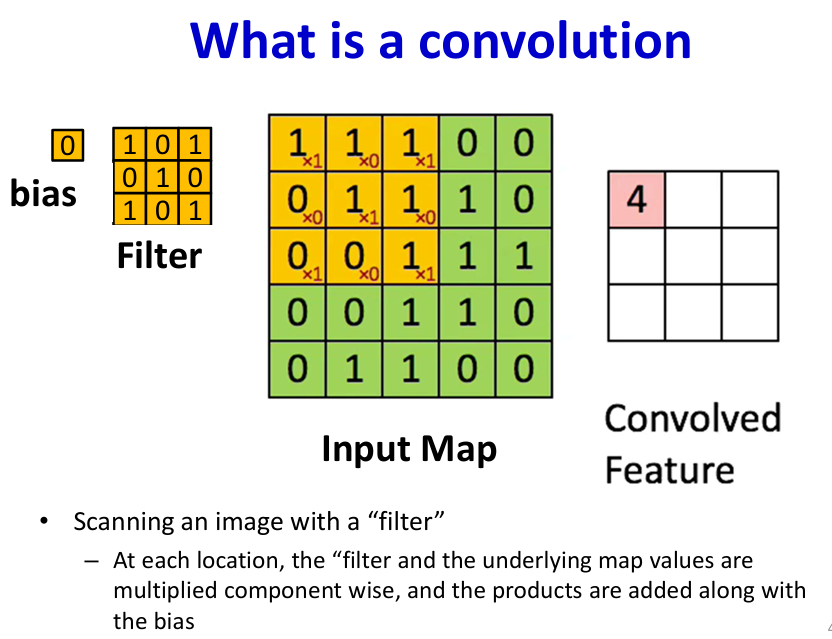

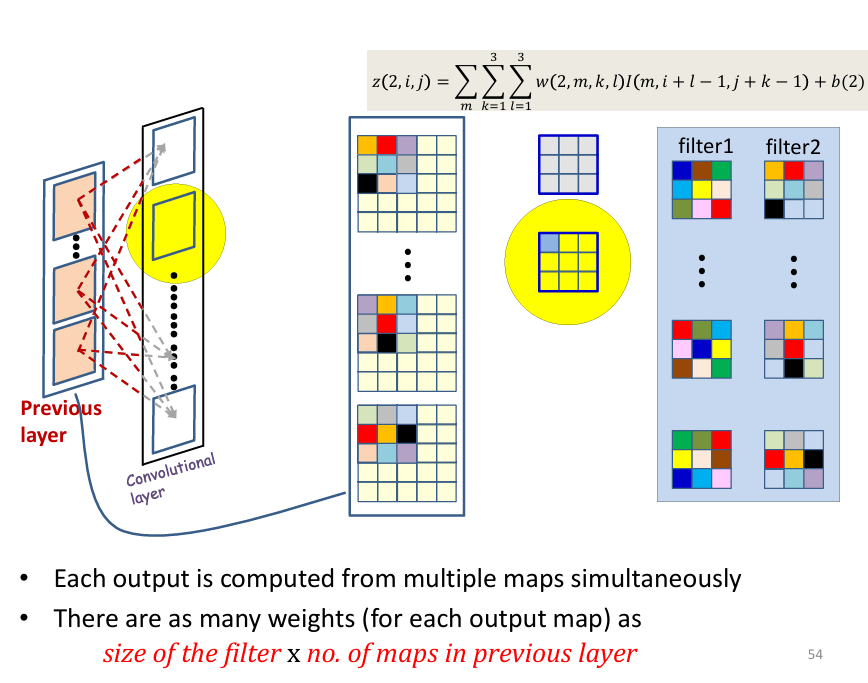

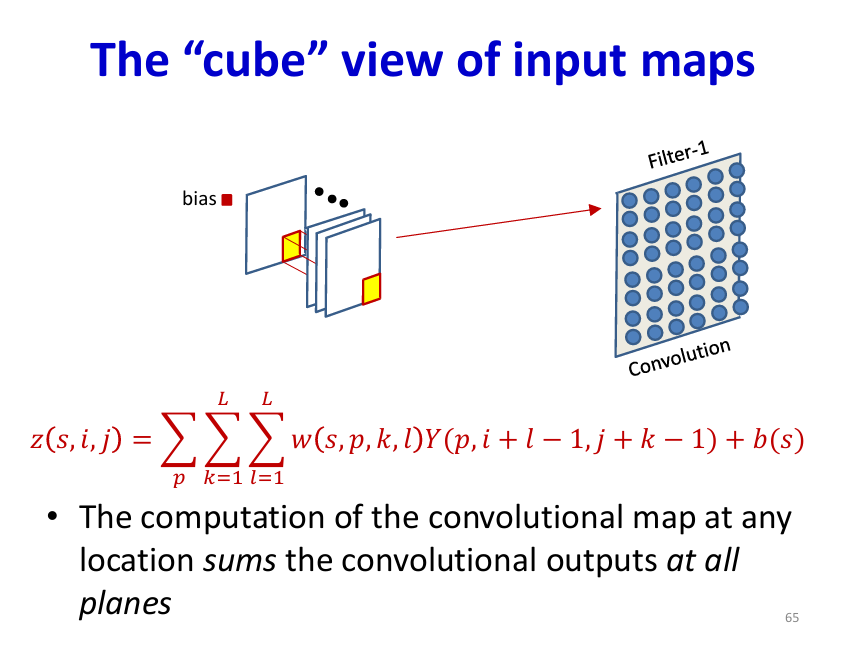

---

### 5.5 Filter Definition

A filter (or kernel) is a small 3-D weight tensor with dimensions:

$$\text{Filter dimensions} = K \times K \times D_{l-1}$$

where:
- $K$ is the spatial kernel size (e.g., 3)
- $D_{l-1}$ is the number of input channels/maps

**Example:**

| Parameter | Value |
|-----------|-------|
| Input maps | 16 |
| Filter spatial size | $3 \times 3$ |
| Full filter tensor | $3 \times 3 \times 16$ |

**Interpretation:** A filter is essentially a single neuron that is reused (shared) at every spatial location. This is the essence of weight sharing.

---

### 5.6 Zero Padding

**Motivation:**

Without padding, convolution shrinks the spatial size of the feature map:

$$\text{Output size (no padding)} = (N - K + 1) \times (N - K + 1)$$

**Consequences without padding:**
- Border pixels are used fewer times than central pixels
- Spatial size shrinks at every layer
- Deep networks lose resolution quickly

**Padding Rules for Filter Width $K$:**

| Filter Size | Padding Amount |
|-------------|----------------|
| Odd $K$ | Pad $\dfrac{K-1}{2}$ on both sides |
| Even $K$ | Pad $\dfrac{K}{2}$ on one side, $\dfrac{K}{2}-1$ on the other |

**Result with padding:**
- Padded image width: $N + K - 1$
- Output after convolution: $N$ (size preserved)

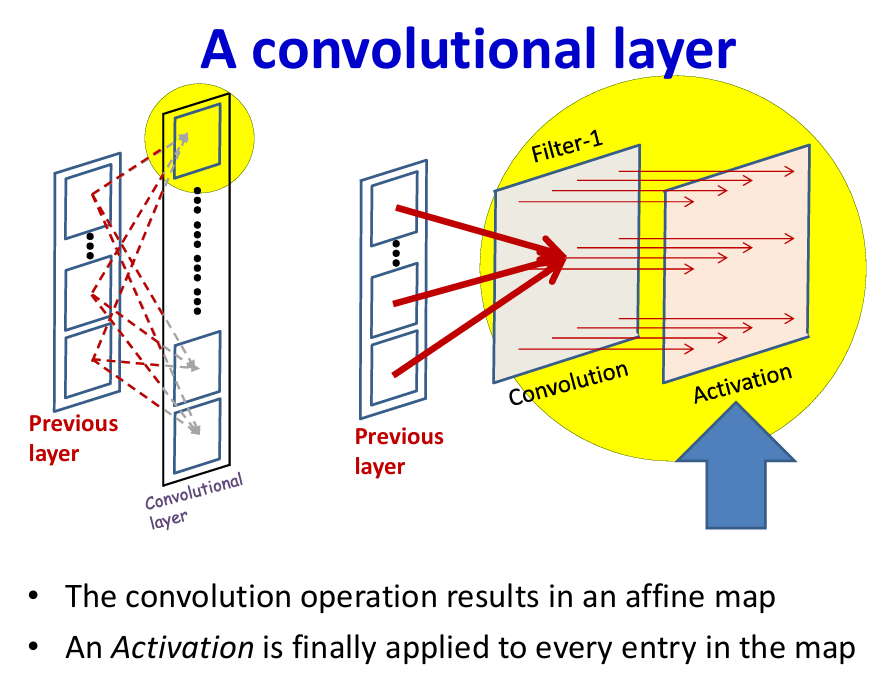

---

### 5.7 Affine Map Computation

**Step-by-Step Process:**

1. Select a local patch of size $K \times K$ from every input map
2. Multiply element-wise: patch values times corresponding filter weights
3. Sum over spatial dimensions $(k, m)$ and all input maps $p$
4. Add bias $b_j$

**Mathematical Formulation:**

$$z_j(x,y) = b_j + \sum_{p=1}^{D_{l-1}} \sum_{k=0}^{K-1} \sum_{m=0}^{K-1} w_{p,j}(k,m) \cdot y_p(x+k, y+m)$$

Then apply activation:

$$Y_j(x,y) = \sigma\left(z_j(x,y)\right)$$

---

### 5.8 Pooling Layer

Pooling operates independently on each map and reduces spatial resolution.

**Properties:**

| Property | Value |
|----------|-------|
| Learnable weights | No |
| Changes number of maps | No |
| Reduces spatial size | Yes |

**Max Pooling Formula:**

For a pooling window of size $P \times P$ with stride $s$:

$$Y_{\text{pool}}(x,y) = \max_{0 \leq k,m < P} \left\{ Y(x \cdot s + k, \; y \cdot s + m) \right\}$$

**Average Pooling Formula:**

$$Y_{\text{pool}}(x,y) = \frac{1}{P^2} \sum_{k=0}^{P-1} \sum_{m=0}^{P-1} Y(x \cdot s + k, \; y \cdot s + m)$$

**Benefits of Pooling:**
- Robustness to small shifts
- Robustness to noise
- Reduces computation in subsequent layers

---

### 5.9 Downsampling

Downsampling reduces spatial dimensions by skipping positions (using stride $S > 1$).

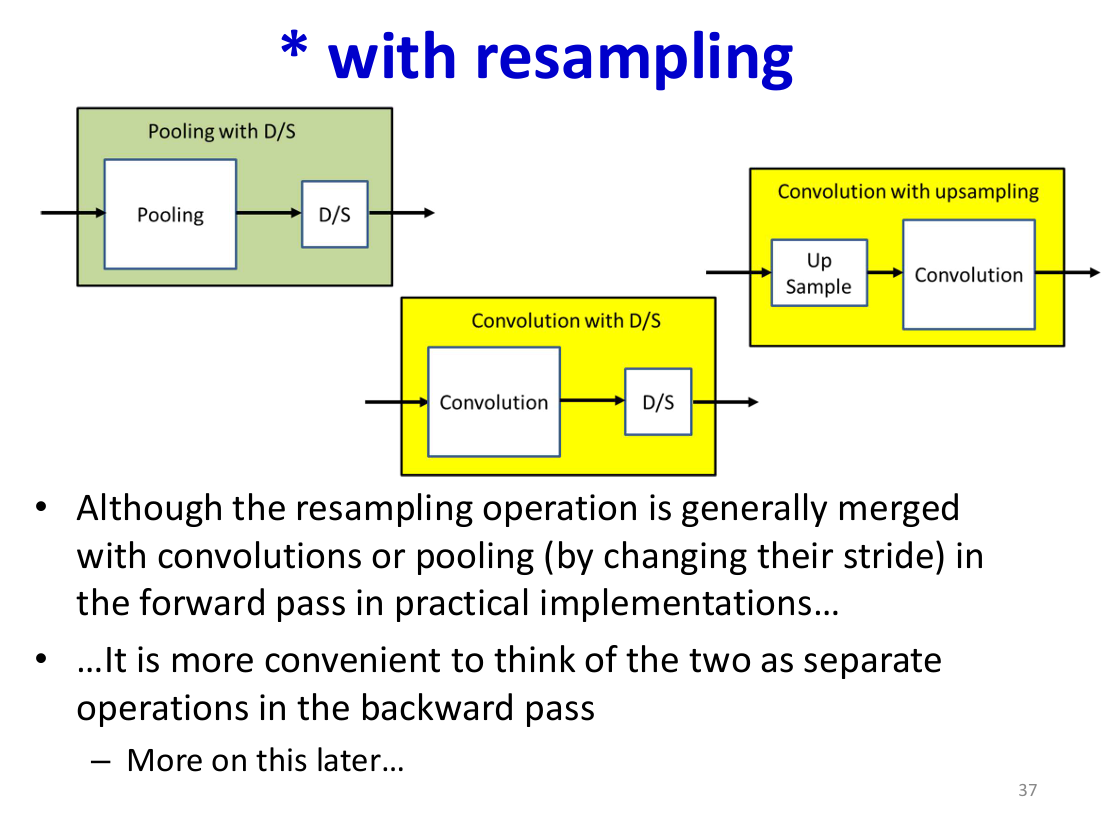

**Output Size Formula:**

$$\text{Output size} = \left\lfloor \frac{N + 2P - K}{S} \right\rfloor + 1$$

where:
- $N$ is the input spatial size
- $P$ is the padding
- $K$ is the filter/pool size
- $S$ is the stride

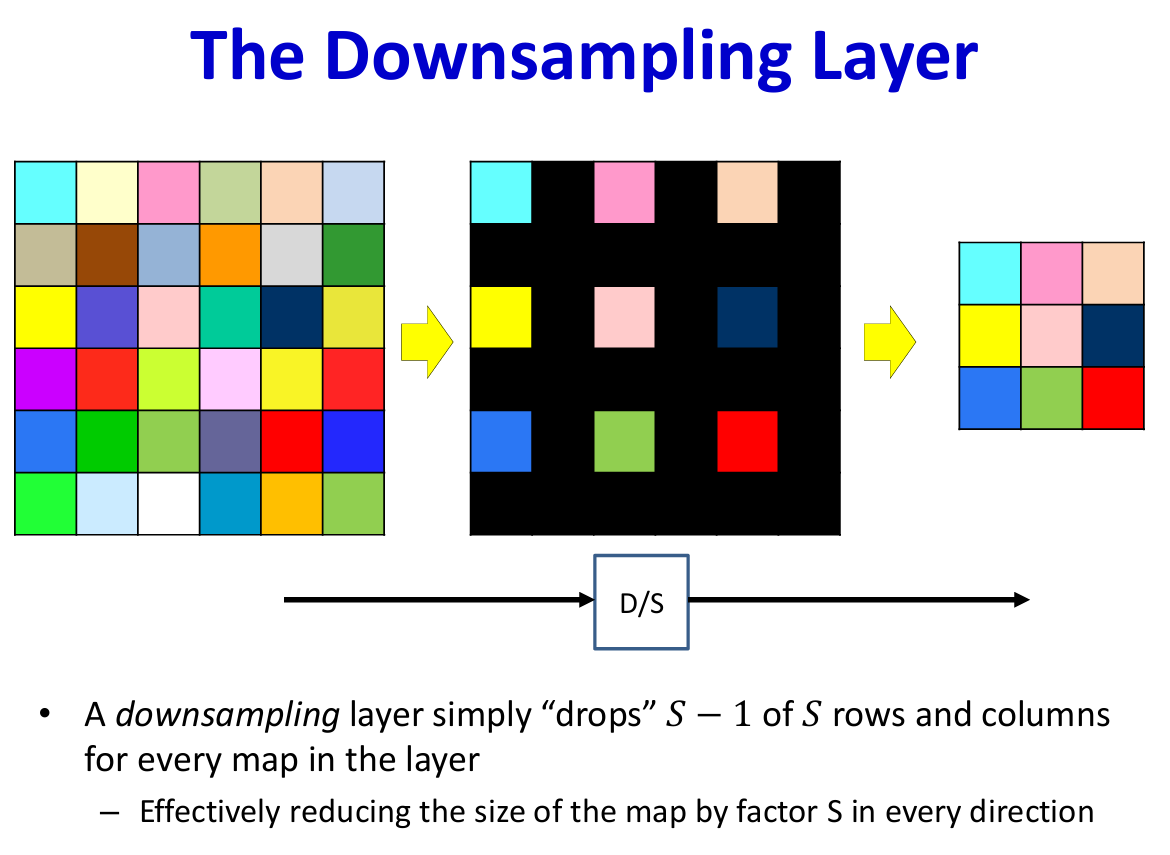

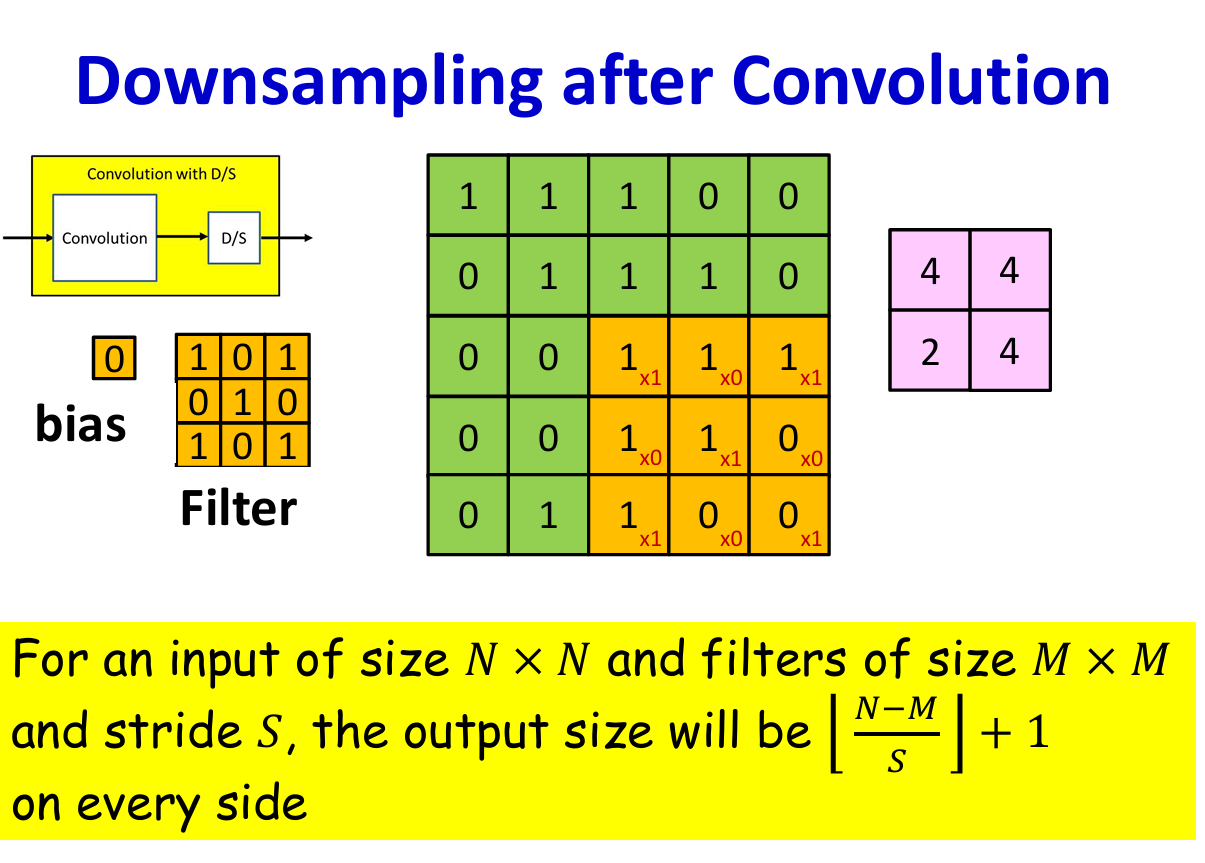

---

### 5.10 Complete CNN Pipeline

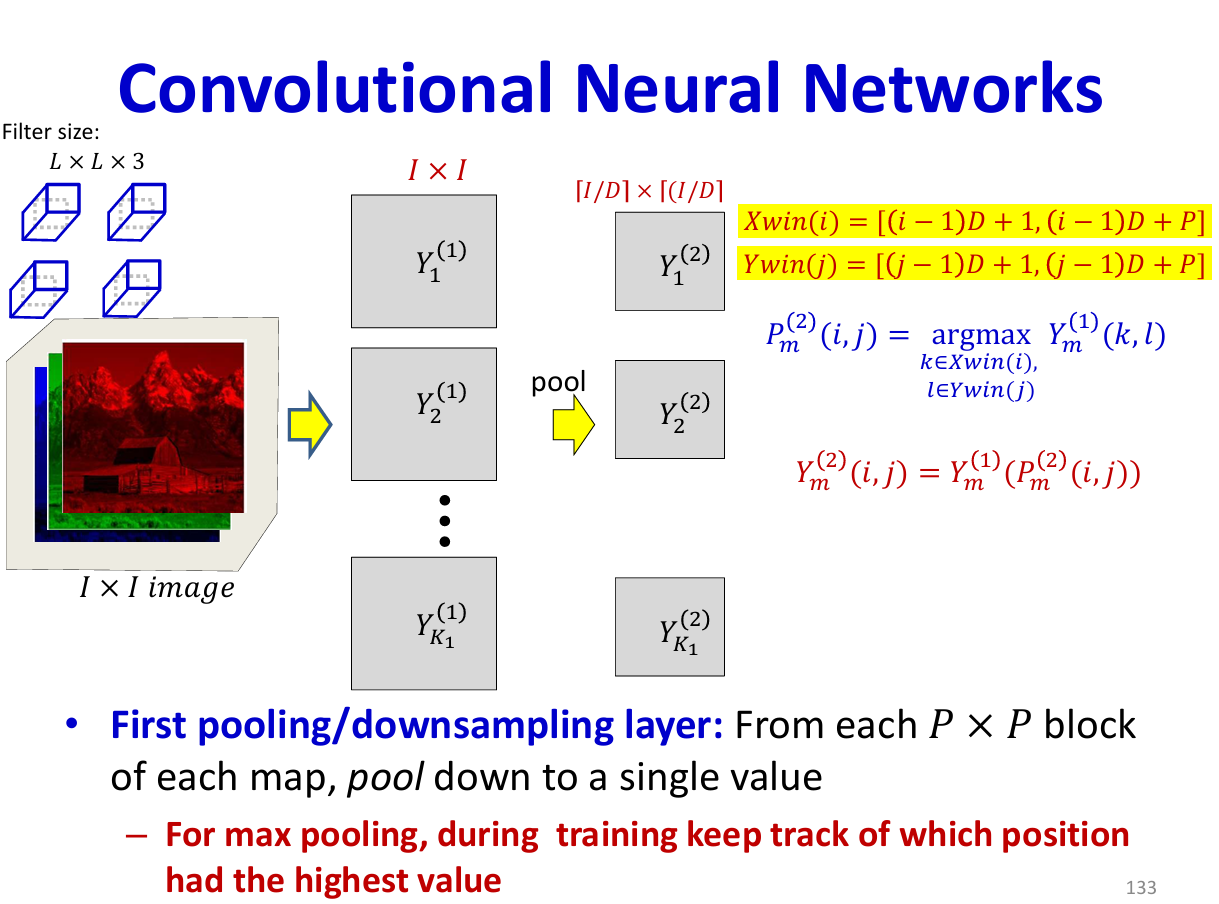

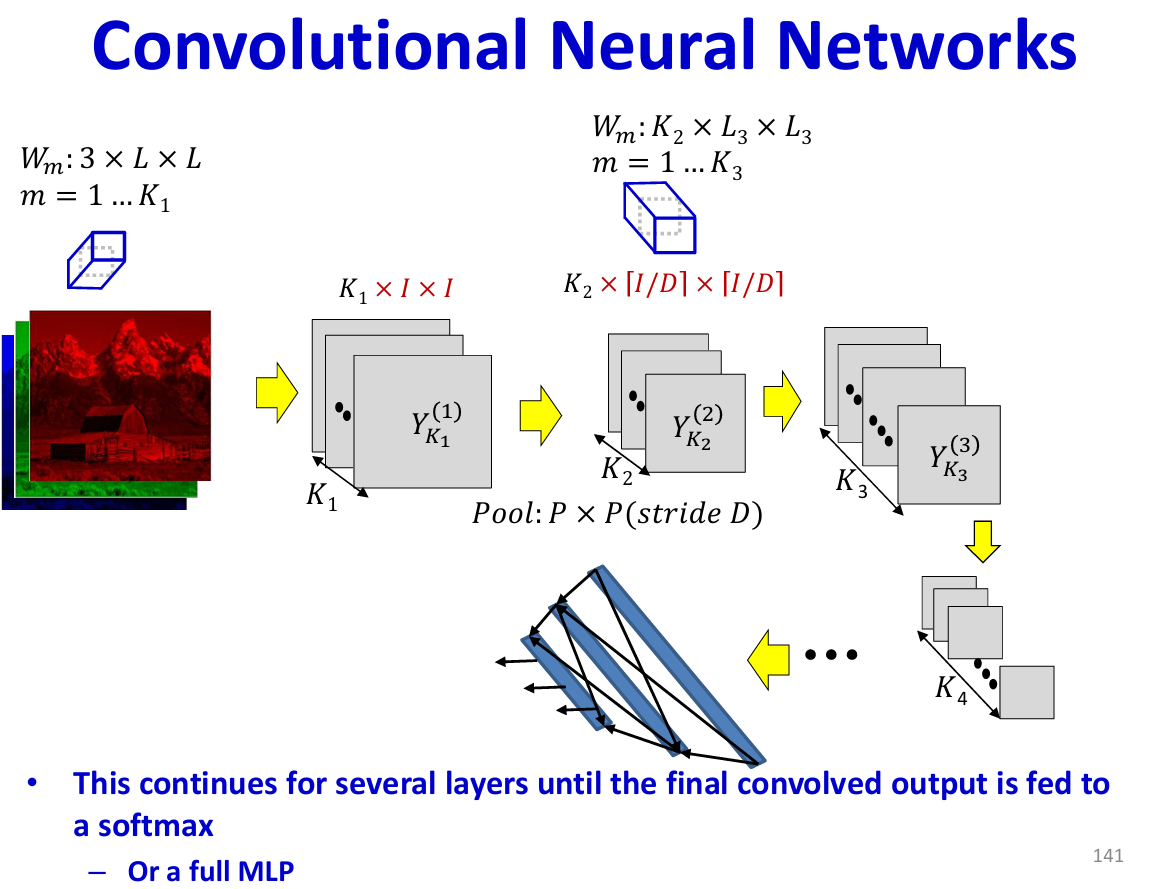

**Data Flow:**

$$\text{Input Image} \rightarrow \text{Convolution} \rightarrow \text{Activation} \rightarrow \text{Pooling} \rightarrow \text{Downsampling} \rightarrow [\text{Repeat}] \rightarrow \text{Flatten} \rightarrow \text{MLP} \rightarrow \text{Softmax}$$

| Stage | Operation | Description |
|:-----:|-----------|-------------|
| 1 | Convolution | Learns local patterns (learnable weights) |
| 2 | Activation | Adds nonlinearity (ReLU, etc.) |
| 3 | Pooling | Robustness to small shifts (fixed operation) |
| 4 | Downsampling | Spatial compression (via stride) |
| 5 | Flatten | Convert feature maps to 1D vector |
| 6 | MLP (FC) | Global reasoning (learnable) |
| 7 | Softmax | Class probabilities |

---

### 5.11 Comparison: Convolution vs Pooling vs Downsampling

| Operation | Learns Parameters | Combines Channels | Changes Values | Changes Size | Main Purpose |
|-----------|:-----------------:|:-----------------:|:--------------:|:------------:|--------------|
| Convolution | Yes | Yes | Yes | Sometimes | Feature extraction |
| Pooling | No | No | Yes | Yes | Robustness |
| Downsampling | No | No | No | Yes | Compression |

---

### 5.12 Complete Forward Pass Summary

| Step | Operation | Mathematical Expression |
|:----:|-----------|-------------------------|
| 1 | Input image enters CNN | $\mathbf{Y}^{(0)} = \text{Image} \in \mathbb{R}^{H \times W \times C}$ |
| 2 | Convolution computes affine maps | $\mathbf{Z}^{(l)} = \mathbf{W}^{(l)} * \mathbf{Y}^{(l-1)} + \mathbf{b}^{(l)}$ |
| 3 | Activation applied pointwise | $\mathbf{Y}^{(l)} = \sigma(\mathbf{Z}^{(l)})$ |
| 4 | Pooling compresses maps | $\mathbf{Y}^{(l)}_{\text{pool}} = \text{MaxPool}(\mathbf{Y}^{(l)})$ |
| 5 | Steps 2-4 repeat hierarchically | Build feature pyramid |
| 6 | Final maps flattened | $\mathbf{v} = \text{flatten}(\mathbf{Y}^{(L)}) \in \mathbb{R}^{d}$ |
| 7 | MLP produces output | $\hat{\mathbf{y}} = \text{softmax}(\mathbf{W}_{fc}\mathbf{v} + \mathbf{b}_{fc})$ |

---

### 5.13 Named Components Reference

| Category | Components |
|----------|------------|
| Input | Input image, Input tensor |
| Feature Extraction | Feature maps, Activation maps, Filters/Kernels |
| Computation | Affine map (pre-activation), Bias, Activation function |
| Spatial Processing | Pooling window, Stride, Downsampling, Zero padding |
| Classification | Flattening, Fully connected layer, Softmax/Output layer |

## Part 6: Backpropagation in CNNs -- Introduction

### 6.1 Overview

Pattern classification tasks such as "does this picture contain a cat" or "does this recording include HELLO" are best performed by scanning for the target pattern.

**Key Concepts:**
- Scanning an input with a network and combining the outcomes is equivalent to scanning with individual neurons hierarchically
- First-level neurons scan the input
- Higher-level neurons scan the "maps" formed by lower-level neurons
- A final decision unit or layer makes the final decision
- Deformations in the input can be handled by pooling

**Terminology:**
- For 2-D (or higher-dimensional) scans, the structure is called a Convolutional Neural Network (CNN)
- For 1-D scan along time, it is called a Time-Delay Neural Network (TDNN)

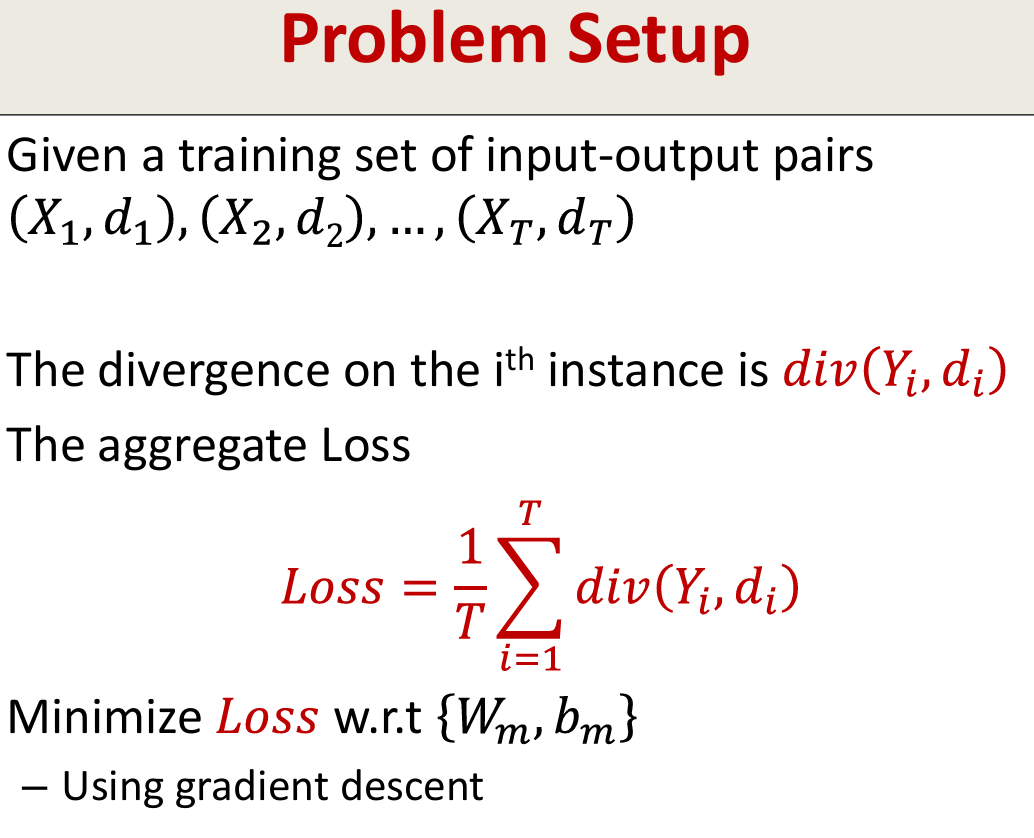

---

### 6.2 The Backpropagation Problem in CNNs

The network learns by performing backpropagation. CNNs require several modifications to standard backpropagation due to weight sharing.

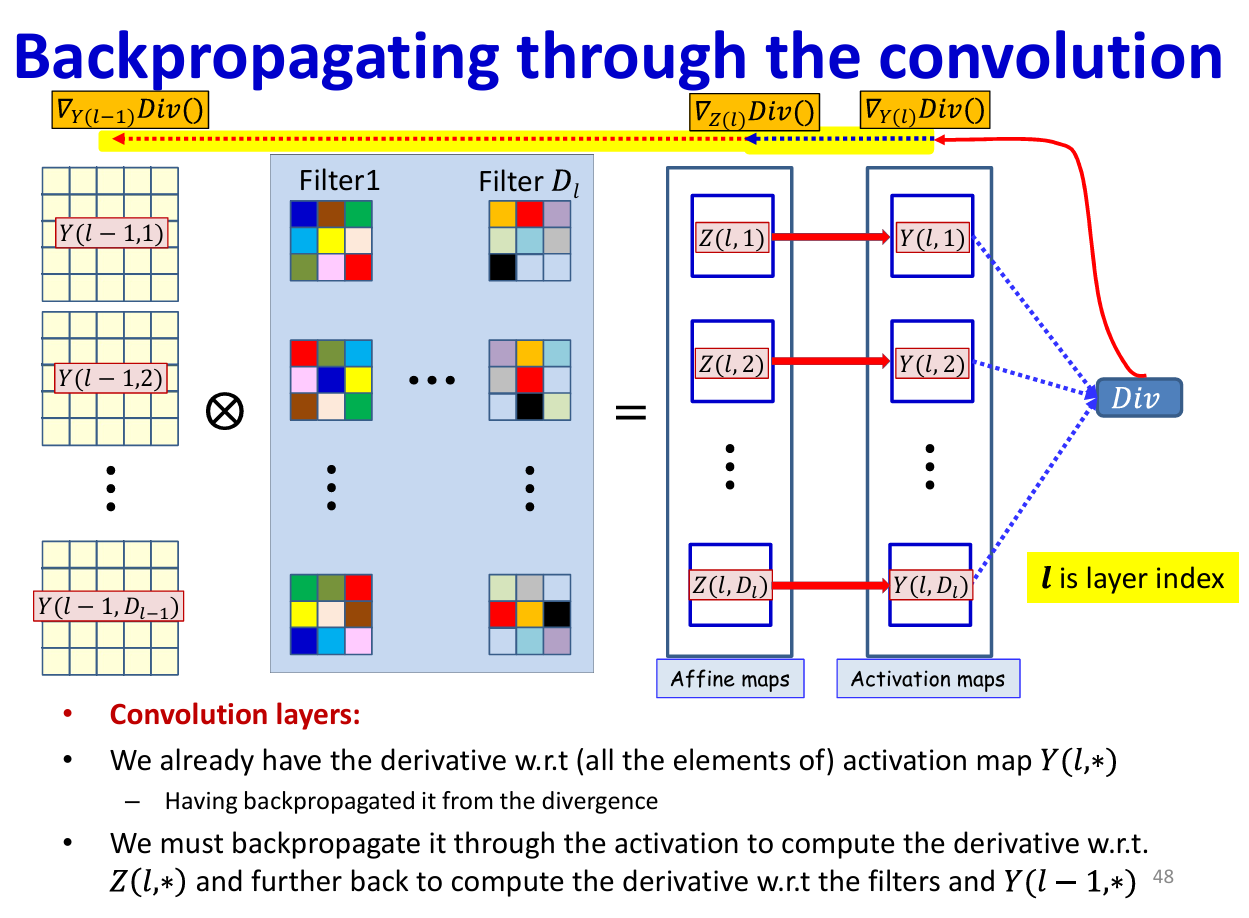

**The Central Question:**

How must standard backpropagation be modified when the same parameter is used multiple times, as in CNNs?

---

### 6.3 Gradient Summation for Shared Parameters

For shared parameters, the gradient is the sum of gradients from all locations where the parameter is used.

Formally, if a parameter $w$ is shared across a set of edges $S$:

$$\frac{\partial \mathcal{L}}{\partial w} = \sum_{e \in S} \frac{\partial \mathcal{L}}{\partial w_e}$$

This summation follows directly from the chain rule and is not optional.

---

### 6.4 What Summation Means in CNNs

Consider a single filter weight $w_{m,n,i,j}$ which:
- Connects input channel $m$ to output channel $n$
- Appears at every spatial position $(x,y)$

The same weight appears in $z^{(l)}_{n,x,y}$ for all $(x,y)$.

Therefore, the gradient is:

$$\frac{\partial \mathcal{L}}{\partial w_{m,n,i,j}} = \sum_{x,y} \frac{\partial \mathcal{L}}{\partial z^{(l)}_{n,x,y}} \cdot y^{(l-1)}_{m,x+i,y+j}$$

This summation over $(x,y)$ is the fundamental CNN modification to backpropagation.

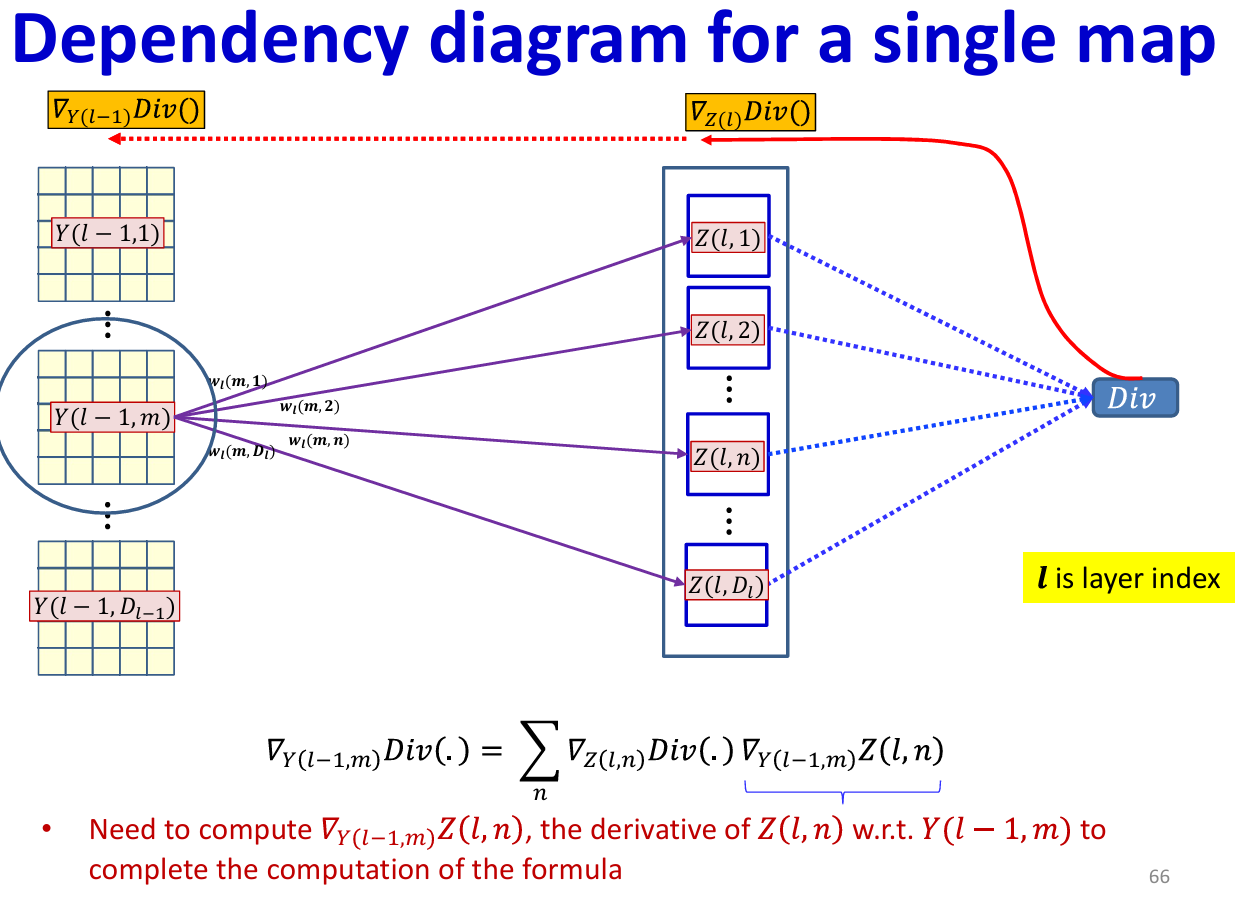

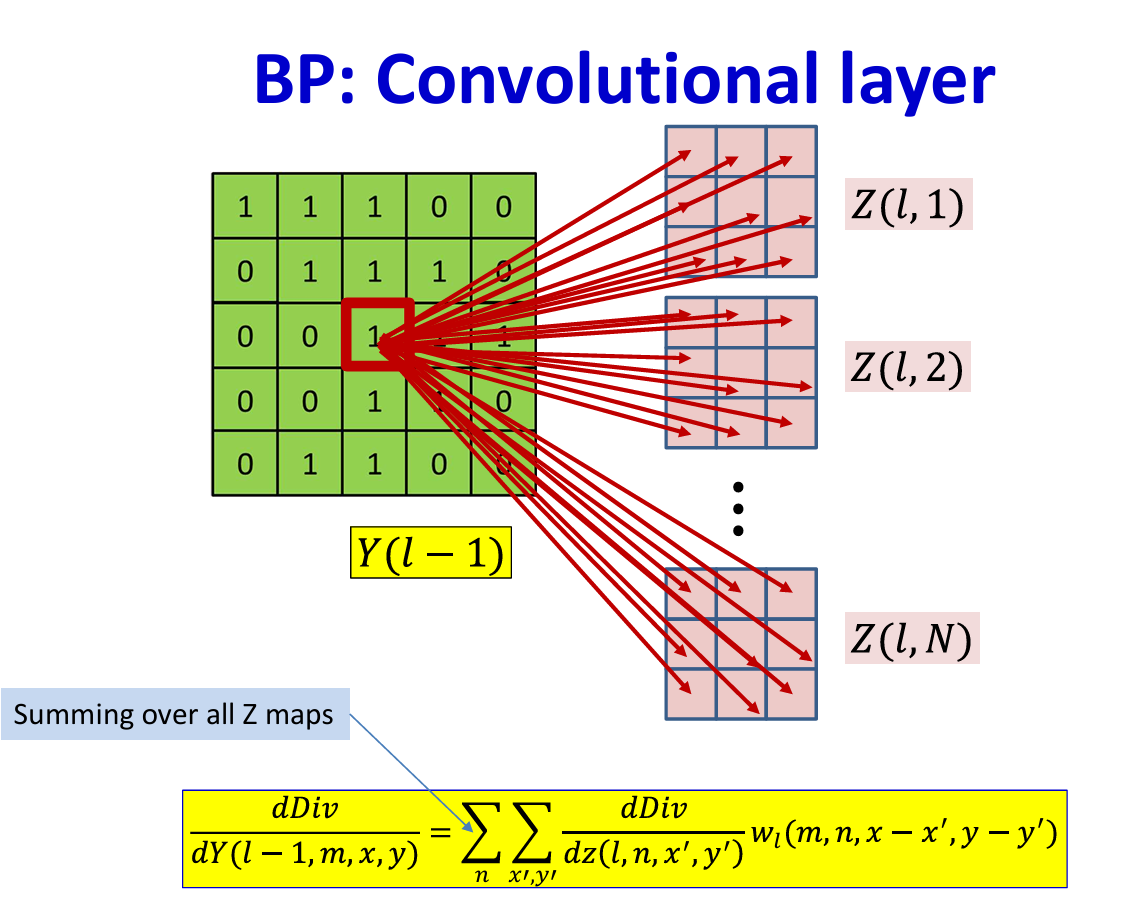

## Part 7: Backpropagation Through Pooling Layers

**Central Question:** How does the gradient flow backward through a pooling operation that has no learnable parameters?

---

### 7.1 Why Pooling Needs Special Treatment

Pooling layers have the following characteristics:
- No learnable weights
- Perform nonlinear, non-invertible operations
- Reduce spatial resolution

Yet gradients must still flow backward; otherwise, earlier convolutional layers cannot learn.

**Key difference from convolution:**
- No gradient with respect to parameters
- Only gradients with respect to inputs

---

### 7.2 Backpropagation Through Max Pooling

**Forward Pass:**

For each pooling window:
1. Select the maximum value
2. Store the argmax index (location of max)

This storage is critical for the backward pass.

**Backward Pass:**

The gradient flows only to the location that was maximal in the forward pass.

Formally, for a pooling window $\Omega$:

$$\frac{\partial \mathcal{L}}{\partial y^{(l-1)}_{i,j}} = \begin{cases} \dfrac{\partial \mathcal{L}}{\partial y^{(l)}_{x,y}} & \text{if } (i,j) = \arg\max_{\Omega} \\ 0 & \text{otherwise} \end{cases}$$

**Intuition:**
- Max pooling is a selection operation
- Only the selected input influenced the output
- All other inputs are ignored and receive zero gradient

**Consequences:**
- Max pooling creates sparse gradients
- Learning becomes more selective and more stable to noise
- However, gradient information is partially discarded

---

### 7.3 Backpropagation Through Mean (Average) Pooling

**Forward Pass:**

Compute the mean over a window of size $K \times K$:

$$y^{(l)}_{x,y} = \frac{1}{K^2} \sum_{(i,j) \in \Omega} y^{(l-1)}_{i,j}$$

**Backward Pass:**

The gradient is equally distributed to all inputs in the pooling window:

$$\frac{\partial \mathcal{L}}{\partial y^{(l-1)}_{i,j}} = \frac{1}{K^2} \frac{\partial \mathcal{L}}{\partial y^{(l)}_{x,y}} \quad \forall (i,j) \in \Omega$$

**Intuition:**
- Mean pooling treats all inputs symmetrically
- Each input contributes equally to the output
- Therefore, the gradient is split evenly

---

### 7.4 What Pooling Does Not Do

| Operation | Pooling Layer |
|-----------|---------------|
| Parameter updates | No |
| Learning | No |
| Weight gradients | No |

Pooling only routes gradients; it does not generate them.

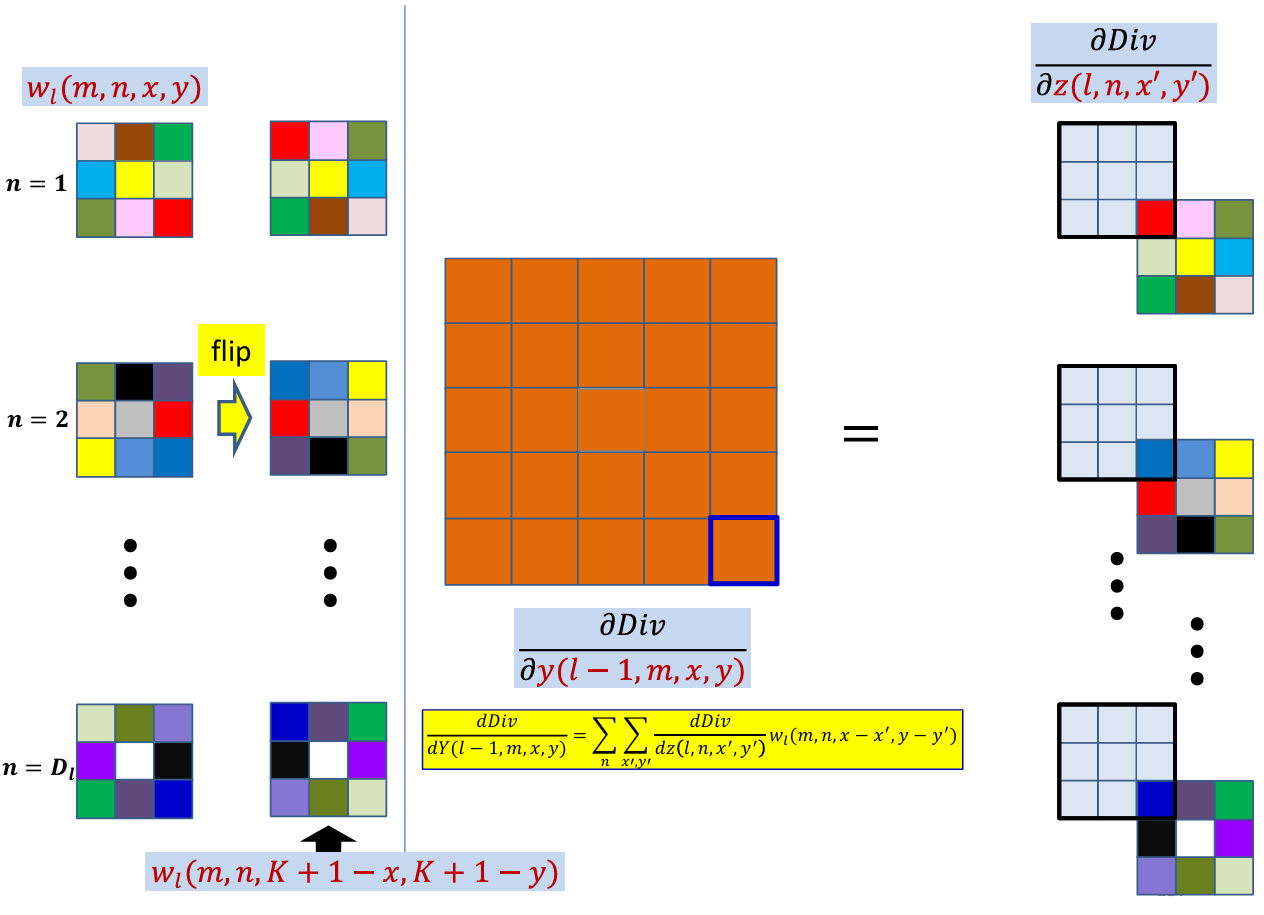

## Part 8: Backpropagation to Previous Feature Maps

### 8.1 What Is Known at This Stage

After completing:
- Backpropagation through MLP
- Backpropagation through activation
- Backpropagation through pooling

We already have:

$$\frac{\partial \mathcal{L}}{\partial z^{(l)}_{n,x,y}}$$

for every output map $n$ and every spatial location $(x,y)$.

Now we must compute:

$$\frac{\partial \mathcal{L}}{\partial y^{(l-1)}_{m,x,y}}$$

for every input map $m$.

---

### 8.2 Why This Is Non-Trivial

In a convolutional layer:

$$z^{(l)}_{n,x,y} = \sum_{m} \sum_{i,j} w^{(l)}_{m,n,i,j} \cdot y^{(l-1)}_{m,x+i,y+j}$$

A single input activation $y^{(l-1)}_{m,x,y}$ influences many outputs across:
- Different output channels $n$
- Different spatial positions $(x',y')$

Therefore, its gradient is the sum of all those influences.

---

### 8.3 Chain Rule Applied to Feature Maps

Using the chain rule:

$$\frac{\partial \mathcal{L}}{\partial y^{(l-1)}_{m,x,y}} = \sum_{n} \sum_{x',y'} \frac{\partial \mathcal{L}}{\partial z^{(l)}_{n,x',y'}} \cdot \frac{\partial z^{(l)}_{n,x',y'}}{\partial y^{(l-1)}_{m,x,y}}$$

---

### 8.4 When Does an Input Affect an Output?

From the forward convolution equation, $y^{(l-1)}_{m,x,y}$ affects $z^{(l)}_{n,x',y'}$ if and only if:

$$x = x' + i \quad \text{and} \quad y = y' + j$$

for some filter indices $(i,j)$. This geometric constraint is crucial.

---

### 8.5 Substituting the Derivative

The partial derivative:

$$\frac{\partial z^{(l)}_{n,x',y'}}{\partial y^{(l-1)}_{m,x,y}} = w^{(l)}_{m,n,x-x',y-y'}$$

Substituting into the chain rule:

$$\frac{\partial \mathcal{L}}{\partial y^{(l-1)}_{m,x,y}} = \sum_{n} \sum_{x',y'} \frac{\partial \mathcal{L}}{\partial z^{(l)}_{n,x',y'}} \cdot w^{(l)}_{m,n,x-x',y-y'}$$

---

### 8.6 Why This Is a Convolution

Observe that:
- We are sliding the filter over the gradient maps
- The filter indices appear as $(x-x', y-y')$

This implies the filter is:
- Flipped left-right
- Flipped up-down

**Conclusion:** Backpropagation to feature maps is a convolution with flipped filters, summed over output channels.

---

### 8.7 Zero Padding and Output Size

To compute gradients at border locations:
- Gradient maps must be zero-padded
- Padding size: $K-1$ on all sides

After convolution:
- Padding is removed
- Output gradient map matches the size of the original input map

---

### 8.8 Interpretation: Transpose Convolution

This operation is often called:
- Transpose convolution
- Deconvolution (misleading terminology)

**Important clarification:**
- No inversion is happening
- This is simply the adjoint of the forward convolution

---

### 8.9 Mental Model

**Forward Pass:**
$$\text{Input map} \rightarrow \text{many outputs (sliding filter)}$$

**Backward Pass:**
$$\text{Many outputs} \rightarrow \text{one input (accumulate all influences)}$$

This symmetry explains:
- Filter flipping
- Gradient summation
- Why CNN backpropagation is still a linear operation

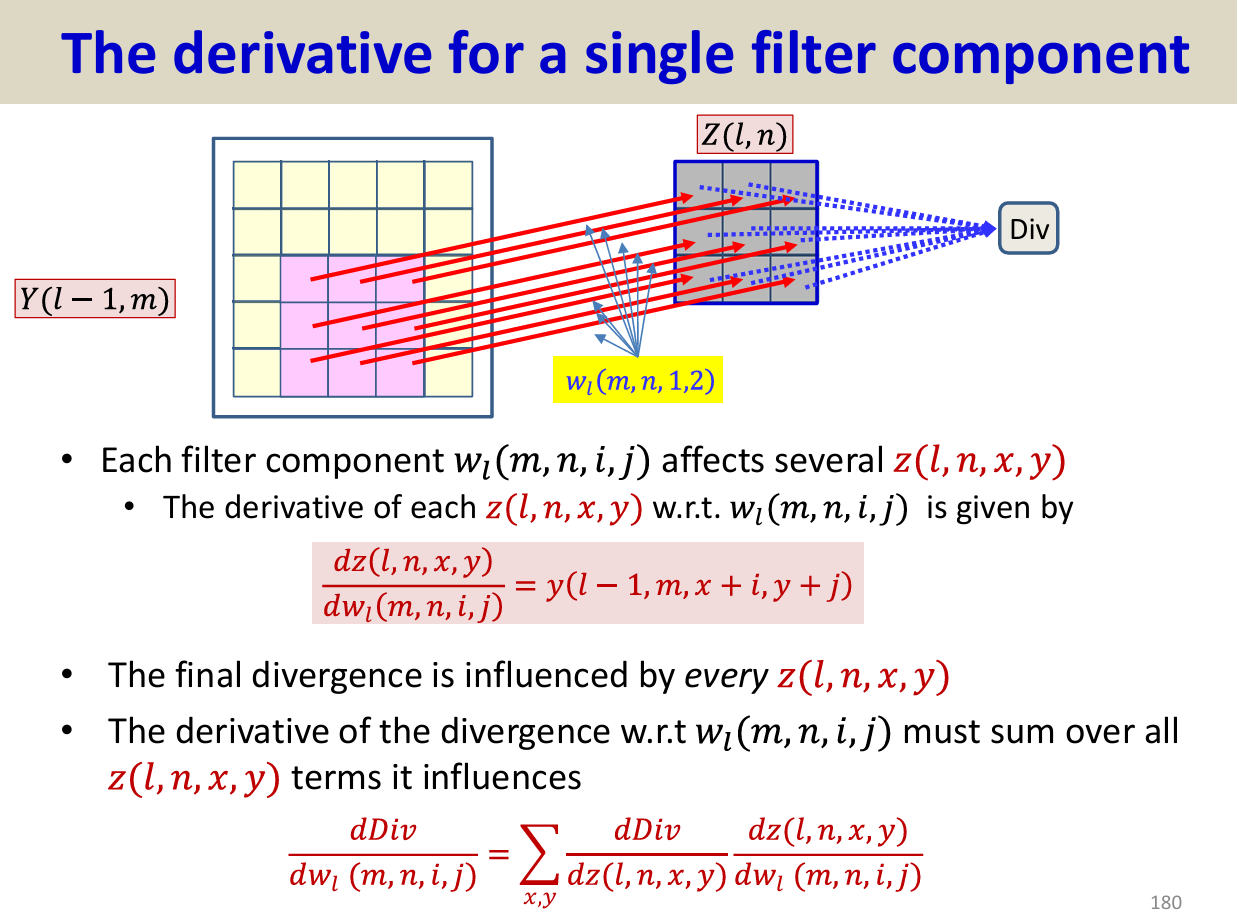

## Part 9: Computing Gradients for Convolutional Filters

This section completes the backpropagation derivation for CNNs by computing $\frac{\partial \mathcal{L}}{\partial W}$ for CNN layers.

---

### 9.1 What Remains to Be Computed

At this point, we already have:

$$\frac{\partial \mathcal{L}}{\partial z^{(l)}_{n,x,y}}$$

(the error signal at each output map location).

What we still need:

$$\frac{\partial \mathcal{L}}{\partial w^{(l)}_{m,n,i,j}}$$

for:
- Input channel $m$
- Output channel $n$
- Kernel offsets $(i,j)$

---

### 9.2 Forward Convolution (Recall)

For reference, the forward pass:

$$z^{(l)}_{n,x,y} = \sum_{m} \sum_{i,j} w^{(l)}_{m,n,i,j} \cdot y^{(l-1)}_{m,x+i,y+j}$$

This equation is what we differentiate.

---

### 9.3 Applying the Chain Rule

Using the chain rule:

$$\frac{\partial \mathcal{L}}{\partial w^{(l)}_{m,n,i,j}} = \sum_{x,y} \frac{\partial \mathcal{L}}{\partial z^{(l)}_{n,x,y}} \cdot \frac{\partial z^{(l)}_{n,x,y}}{\partial w^{(l)}_{m,n,i,j}}$$

---

### 9.4 Computing the Partial Derivative

From the forward equation:

$$\frac{\partial z^{(l)}_{n,x,y}}{\partial w^{(l)}_{m,n,i,j}} = y^{(l-1)}_{m,x+i,y+j}$$

Substituting:

$$\frac{\partial \mathcal{L}}{\partial w^{(l)}_{m,n,i,j}} = \sum_{x,y} \frac{\partial \mathcal{L}}{\partial z^{(l)}_{n,x,y}} \cdot y^{(l-1)}_{m,x+i,y+j}$$

This is the exact gradient formula for filter weights.

---

### 9.5 Interpretation as a Convolution

Observe the structure:
- We slide the input feature map
- Multiply by the error map
- Accumulate over all spatial positions

Thus:

$$\text{Filter gradient} = \text{convolution of input map with output error map}$$

**Note on flipping:**
- No flipping is required if forward convolution is defined as cross-correlation (as in most deep learning libraries)
- If forward pass uses true convolution, filter gradients involve flipping

---

### 9.6 Multi-Channel and Batch Effects

| Scenario | Gradient Computation |
|----------|---------------------|
| Multiple input channels | Sum over $m$ |
| Multiple output channels | One gradient per $(m,n)$ filter |
| Mini-batch training | $\frac{\partial \mathcal{L}}{\partial w} = \sum_{\text{batch}} \sum_{x,y} (\cdot)$ |

Gradients accumulate across:
- Spatial locations
- Channels
- Training examples

---

### 9.7 Bias Gradient

The bias term appears as:

$$z^{(l)}_{n,x,y} = \cdots + b^{(l)}_n$$

The derivative:

$$\frac{\partial \mathcal{L}}{\partial b^{(l)}_n} = \sum_{x,y} \frac{\partial \mathcal{L}}{\partial z^{(l)}_{n,x,y}}$$

Bias gradients are simply sums of error maps.

---

### 9.8 Full CNN Backpropagation Summary (Single Layer)

For one convolutional layer:

| Gradient | Formula |
|----------|---------|
| Activation gradient | $\delta = \frac{\partial \mathcal{L}}{\partial y} \odot f'(z)$ |
| Filter gradient | $\frac{\partial \mathcal{L}}{\partial W} = \text{input} * \delta$ |
| Input gradient | $\frac{\partial \mathcal{L}}{\partial \text{input}} = \delta * W_{\text{flipped}}$ |
| Bias gradient | $\frac{\partial \mathcal{L}}{\partial b} = \sum \delta$ |

where $*$ denotes a convolution-like operation and $\odot$ denotes element-wise multiplication.

---

### 9.9 Why This Completes CNN Backpropagation

At this point, we can:
1. Propagate gradients backward through all layers
2. Compute gradients for all parameters
3. Update filters using gradient descent

**Conclusion:** CNNs are trained with standard backpropagation, correctly extended for shared parameters and spatial structure.

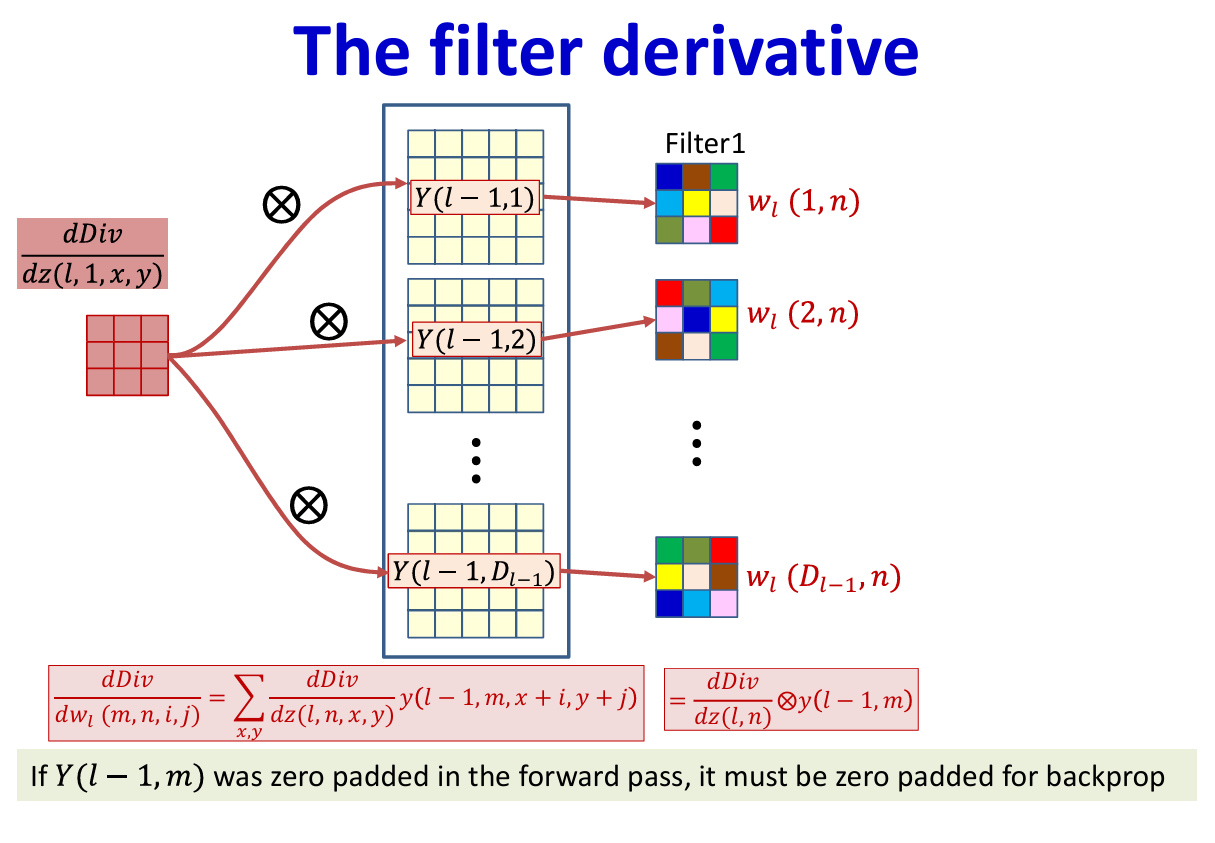

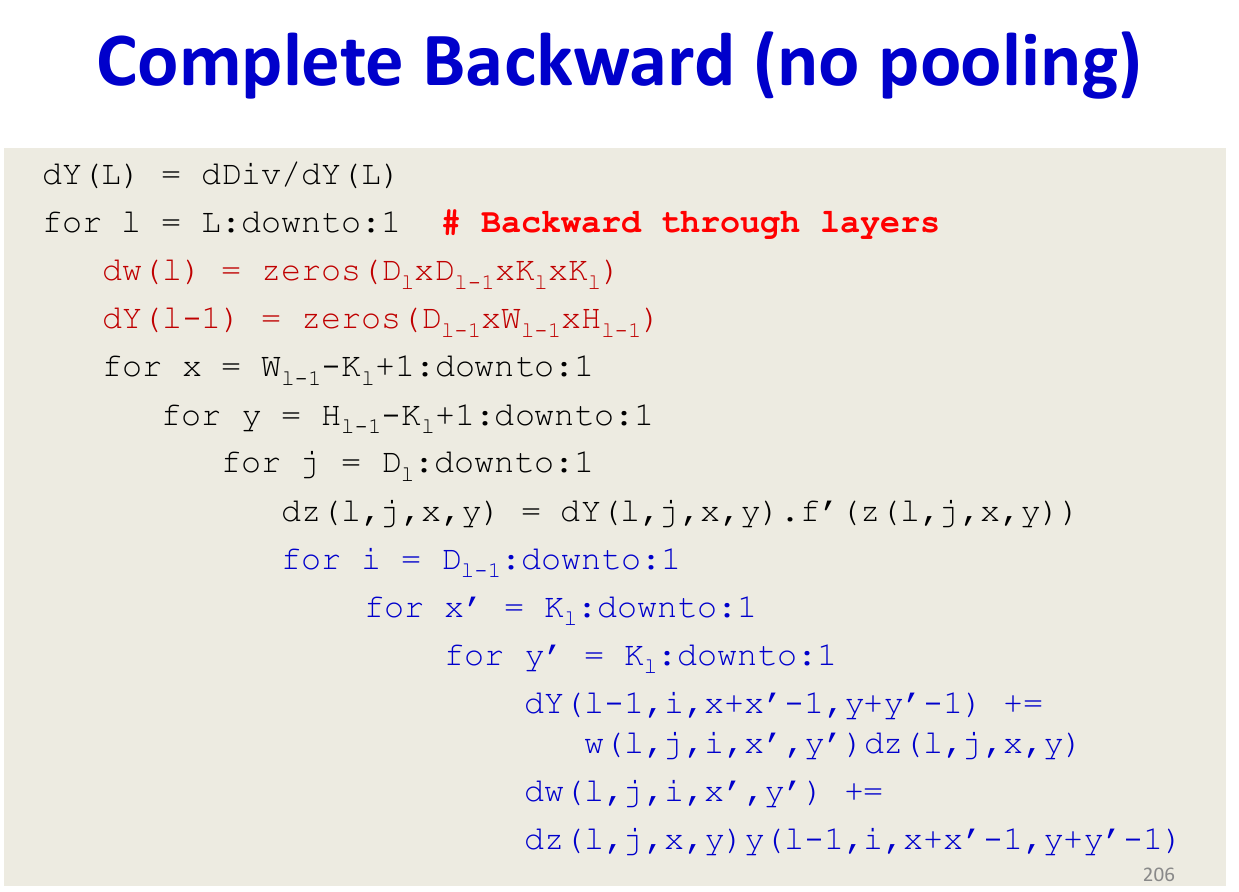